# DAX Benchmarks

In [1]:
import json
import numpy as np
import pandas as pd
import sempy.fabric as fabric
import statistics as stats
import time
import uuid

from pyspark.sql import functions as F

StatementMeta(, 35356e45-f61f-4e43-b61f-b0d0db6fafa2, 6, Finished, Available, Finished)

## Parameters

In [ ]:
WORKSPACE = None  # same workspace as notebook/lakehouse; set name/ID if needed

DATASETS = {
    "SS": "Star Schema",
    "USS": "Unified Star Schema",
}

MIN_MEASURED = 1    # don't stop before this many measured runs
MAX_MEASURED = 1   # hard cap
WARMUP = 0          # still run warmups, but store them
CV_TARGET = 0.00    # 0% coefficient of variation
ERROR_LIMIT = 1     # if a query errors too much, stop early

StatementMeta(, 35356e45-f61f-4e43-b61f-b0d0db6fafa2, 7, Finished, Available, Finished)

## Helpers

In [ ]:
import matplotlib.pyplot as plt

# Global accumulator for all runs
GLOBAL_RUNS = []

# Fact table mapping
FACT_FOR_MEASURE_PREFIX = {
    "SS": {
        "fact": "fact__sales",
        "fact_ret": "fact__returns",
        "fact_inv": "fact__inventory",
    },
    "USS": {
        "fact": "_bridge",
        "fact_ret": "_bridge",
        "fact_inv": "_bridge",
    }
}

def _stable_hash_df(df: pd.DataFrame) -> str:
    if df is None:
        return None
    df2 = df.copy().reindex(sorted(df.columns), axis=1)
    h = pd.util.hash_pandas_object(df2, index=True).values.astype("uint64")
    folded = np.bitwise_xor.reduce(h) if len(h) else np.uint64(0)
    return str(int(folded))

def _df_to_json_payload(df: pd.DataFrame, max_rows: int | None):
    if df is None:
        return None
    truncated = False
    if max_rows is not None and len(df) > max_rows:
        df = df.head(max_rows)
        truncated = True
    return {
        "truncated": truncated,
        "rows": int(len(df)),
        "cols": int(df.shape[1]),
        "columns": list(df.columns),
        "data": json.loads(df.to_json(orient="records", date_format="iso"))
    }

def run_one_dax(dataset_name: str, dax: str, workspace=None) -> pd.DataFrame:
    return fabric.evaluate_dax(dataset=dataset_name, dax_string=dax, workspace=workspace)

def run_and_plot(group, name, template):
    print(f"--- Running {name} ({group}) ---")
    local_runs = []
    
    for suite_key, dataset_name in DATASETS.items():
        mapping = FACT_FOR_MEASURE_PREFIX[suite_key]
        dax = template.format(**mapping)
        
        # Reuse existing run_query_adaptive
        rr, _, stop_reason = run_query_adaptive(
            dataset_name=dataset_name,
            suite_key=suite_key,
            group_name=group,
            qname=name,
            dax=dax,
            workspace=WORKSPACE
        )
        local_runs.extend(rr)
        print(f"[{suite_key}] Stop reason: {stop_reason}")
        
    # Append to global
    GLOBAL_RUNS.extend(local_runs)
    
    # Plot
    df = pd.DataFrame(local_runs)
    if not df.empty:
        measured = df.query("phase == 'measured' and error.isna()")
        if not measured.empty:
            stats = measured.groupby("dataset")["duration_ms"].median()
            ax = stats.plot.barh(figsize=(8, 3), title=f"Median Duration: {name}")
            ax.set_xlabel("ms")
            plt.show()

StatementMeta(, 35356e45-f61f-4e43-b61f-b0d0db6fafa2, 9, Finished, Available, Finished)

In [5]:
def cv(values: list[float]) -> float:
    if len(values) < 2:
        return float("inf")
    mean = stats.fmean(values)
    if mean == 0:
        return float("inf")
    return stats.pstdev(values) / mean

def run_query_adaptive(dataset_name: str, suite_key: str, group_name: str, qname: str, dax: str, workspace=None):
    """
    Runs warmups + measured repetitions until stable by CV_TARGET or cap reached.
    Stores all runs (warmup + measured).
    Returns: (runs_rows, results_rows, stop_reason)
    """
    runs_rows_local = []
    results_rows_local = []

    measured_durations = []
    errors = 0
    seq = 0
    stop_reason = None

    def record(run_phase: str, rep_n: int, duration_ms: float, df, err: str | None):
        nonlocal seq
        seq += 1
        row_count = None if df is None else int(len(df))
        col_count = None if df is None else int(df.shape[1])
        result_hash = None if df is None else _stable_hash_df(df)
        payload = _df_to_json_payload(df, MAX_RESULT_ROWS_TO_STORE)

        runs_rows_local.append({
            "run_id": run_id,
            "started_utc": started_utc,
            "dataset": dataset_name,
            "suite": suite_key,
            "query_group": group_name,
            "query_name": qname,
            "phase": run_phase,          # warmup / measured
            "repeat_n": rep_n,           # within phase
            "seq_in_query": seq,         # across phases
            "duration_ms": float(duration_ms),
            "row_count": row_count,
            "col_count": col_count,
            "result_hash": result_hash,
            "error": err,
        })

        results_rows_local.append({
            "run_id": run_id,
            "dataset": dataset_name,
            "suite": suite_key,
            "query_group": group_name,
            "query_name": qname,
            "phase": run_phase,
            "repeat_n": rep_n,
            "seq_in_query": seq,
            "payload_json": None if payload is None else json.dumps(payload)
        })

    # ---- Warmups (stored) ----
    for w in range(1, WARMUP + 1):
        t0 = time.perf_counter()
        df = None
        err = None
        try:
            df = run_one_dax(dataset_name, dax, workspace=workspace)
        except Exception as e:
            err = str(e); errors += 1
        t1 = time.perf_counter()
        record("warmup", w, (t1 - t0) * 1000.0, df, err)

    # ---- Measured runs (adaptive) ----
    m = 0
    while True:
        m += 1
        t0 = time.perf_counter()
        df = None
        err = None
        try:
            df = run_one_dax(dataset_name, dax, workspace=workspace)
        except Exception as e:
            err = str(e); errors += 1
        t1 = time.perf_counter()

        dur_ms = (t1 - t0) * 1000.0
        record("measured", m, dur_ms, df, err)

        if err is None:
            measured_durations.append(dur_ms)

        # stop conditions
        if errors >= ERROR_LIMIT:
            stop_reason = "error_limit"
            break

        if m >= MAX_MEASURED:
            stop_reason = "max_measured"
            break

        if len(measured_durations) >= MIN_MEASURED:
            current_cv = cv(measured_durations)
            if current_cv <= CV_TARGET:
                stop_reason = f"cv<={CV_TARGET}"
                break

    # annotate stop reason on the LAST run row for this query
    runs_rows_local[-1]["stop_reason"] = stop_reason

    return runs_rows_local, results_rows_local, stop_reason


StatementMeta(, 35356e45-f61f-4e43-b61f-b0d0db6fafa2, 10, Finished, Available, Finished)

## Queries

### Single Fact

In [ ]:
run_and_plot("Single Fact", "P1_sales_by_year", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
ORDER BY 'dim__date'[year]
""")

run_and_plot("Single Fact", "P2_sales_by_year_category", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[category],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
ORDER BY 'dim__date'[year], 'dim__item'[category]
""")

run_and_plot("Single Fact", "P3_sales_many_groups", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[category],
    'dim__store'[_key__dim__store],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
""")

run_and_plot("Single Fact", "P4_top100_items_sales_2002", """
EVALUATE
TOPN(
    100,
    SUMMARIZECOLUMNS(
        'dim__item'[_key__dim__item],
        'dim__item'[category],
        TREATAS( {{ 2002 }}, 'dim__date'[year] ),
        "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
    ),
    [Sales], DESC,
    'dim__item'[_key__dim__item], ASC
)
""")

run_and_plot("Single Fact", "P9_inventory_wh_category_year_2002", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__warehouse'[_key__dim__warehouse],
    'dim__item'[category],
    TREATAS( {{ 2002 }}, 'dim__date'[year] ),
    "Qty On Hand", SUM('{fact_inv}'[_measure__inventory__qty_on_hand])
)
""")

run_and_plot("Single Fact", "P10_sales_yoy_by_year", """
EVALUATE
ADDCOLUMNS(
    SUMMARIZECOLUMNS(
        'dim__date'[year],
        "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
    ),
    "Sales PY",
        CALCULATE(
            SUM('{fact}'[_measure__sales__ext_sales_price]),
            SAMEPERIODLASTYEAR('dim__date'[date])
        ),
    "YoY Δ",
        SUM('{fact}'[_measure__sales__ext_sales_price])
        - CALCULATE(
            SUM('{fact}'[_measure__sales__ext_sales_price]),
            SAMEPERIODLASTYEAR('dim__date'[date])
        ),
    "YoY %",
        DIVIDE(
            SUM('{fact}'[_measure__sales__ext_sales_price])
            - CALCULATE(
                SUM('{fact}'[_measure__sales__ext_sales_price]),
                SAMEPERIODLASTYEAR('dim__date'[date])
            ),
            CALCULATE(
                SUM('{fact}'[_measure__sales__ext_sales_price]),
                SAMEPERIODLASTYEAR('dim__date'[date])
            )
        )
)
ORDER BY 'dim__date'[year]
""")

run_and_plot("Single Fact", "P11_distinct_customers_with_orders", """
EVALUATE
ROW(
    "Distinct Customers With Orders",
    CALCULATE(DISTINCTCOUNT('{fact}'[_key__dim__customer]), NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price]))
)
""")

run_and_plot("Single Fact", "P12_sales_hi_card_group", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__date'[month_of_year],
  'dim__item'[category],
  'dim__store'[_key__dim__store],
  "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
""")

run_and_plot("Single Fact", "P13_top500_items_by_year", """
EVALUATE
TOPN(
  500,
  SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[_key__dim__item],
    'dim__item'[category],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
  ),
  [Sales], DESC,
  'dim__date'[year], ASC,
  'dim__item'[_key__dim__item], ASC
)
""")

run_and_plot("Single Fact", "P15_sales_rolling_90d_by_category", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__date'[month_of_year],
  'dim__item'[category],
  "Sales 90D",
    CALCULATE(
      SUM('{fact}'[_measure__sales__ext_sales_price]),
      DATESINPERIOD('dim__date'[date], MAX('dim__date'[date]), -90, DAY)
    )
)
""")

run_and_plot("Single Fact", "P18_new_customers_yoy", """
EVALUATE
VAR CustThisYear =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustPriorYear =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    SAMEPERIODLASTYEAR('dim__date'[date]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
RETURN
ROW(
  "New Customers (YoY)",
  COUNTROWS( EXCEPT(CustThisYear, CustPriorYear) )
)
""")

run_and_plot("Single Fact", "P19_distinct_customers_hi_card", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[category],
  'dim__store'[_key__dim__store],
  "Distinct Customers",
    CALCULATE(
      DISTINCTCOUNT('{fact}'[_key__dim__customer]),
      NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
    )
)
""")

run_and_plot("Single Fact", "P20_hi_card_30d_distinct_customers", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[_key__dim__item],
  "Distinct Customers 30D",
    CALCULATE(
      DISTINCTCOUNT('{fact}'[_key__dim__customer]),
      DATESINPERIOD('dim__date'[date], MAX('dim__date'[date]), -30, DAY)
    )
)
""")

run_and_plot("Single Fact", "P21_massive_group_distinct_customers_day_item_store", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__date'[month_of_year],
  'dim__item'[_key__dim__item],
  'dim__store'[_key__dim__store],
  "Distinct Customers",
    DISTINCTCOUNT('{fact}'[_key__dim__customer])
)
""")


StatementMeta(, 35356e45-f61f-4e43-b61f-b0d0db6fafa2, 11, Finished, Available, Finished)

[SS] P1_sales_by_year stop_reason=max_measured
[SS] P2_sales_by_year_category stop_reason=max_measured
[SS] P3_sales_many_groups stop_reason=max_measured
[SS] P4_top100_items_sales_2002 stop_reason=max_measured
[SS] P9_inventory_wh_category_year_2002 stop_reason=max_measured
[SS] P10_sales_yoy_by_year stop_reason=max_measured
[SS] P11_distinct_customers_with_orders stop_reason=max_measured
[SS] P12_sales_hi_card_group stop_reason=max_measured
[SS] P13_top500_items_by_year stop_reason=max_measured
[SS] P15_sales_rolling_90d_by_category stop_reason=max_measured
[SS] P18_new_customers_yoy stop_reason=max_measured
[SS] P19_distinct_customers_hi_card stop_reason=max_measured
[SS] P20_hi_card_30d_distinct_customers stop_reason=max_measured
[SS] P21_massive_group_distinct_customers_day_item_store stop_reason=error_limit
[SS] P5_net_sales_by_month stop_reason=max_measured
[SS] P14_return_rate_by_year_category stop_reason=max_measured
[SS] P16_distinct_customers_sales_or_returns stop_reason=max

### Multi Fact

In [ ]:
run_and_plot("Multi Fact", "P5_net_sales_by_month", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__date'[month_of_year],
    "Sales",   SUM('{fact}'[_measure__sales__ext_sales_price]),
    "Returns", SUM('{fact_ret}'[_measure__returns__return_amt]),
    "Net",
        SUM('{fact}'[_measure__sales__ext_sales_price])
        - SUM('{fact_ret}'[_measure__returns__return_amt])
)
ORDER BY 'dim__date'[year], 'dim__date'[month_of_year]
""")

run_and_plot("Multi Fact", "P14_return_rate_by_year_category", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[category],
  "Sales",   SUM('{fact}'[_measure__sales__ext_sales_price]),
  "Returns", SUM('{fact_ret}'[_measure__returns__return_amt]),
  "Return Rate",
    DIVIDE(
      SUM('{fact_ret}'[_measure__returns__return_amt]),
      SUM('{fact}'[_measure__sales__ext_sales_price])
    )
)
ORDER BY 'dim__date'[year], 'dim__item'[category]
""")

run_and_plot("Multi Fact", "P16_distinct_customers_sales_or_returns", """
EVALUATE
VAR CustSales =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustReturns =
  CALCULATETABLE(
    VALUES('{fact_ret}'[_key__dim__customer]),
    NOT ISBLANK('{fact_ret}'[_measure__returns__return_amt])
  )
RETURN
ROW(
  "Distinct Customers (Sales OR Returns)",
  COUNTROWS( DISTINCT( UNION(CustSales, CustReturns) ) )
)
""")

run_and_plot("Multi Fact", "P17_customers_sales_and_returns", """
EVALUATE
VAR CustSales =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustReturns =
  CALCULATETABLE(
    VALUES('{fact_ret}'[_key__dim__customer]),
    NOT ISBLANK('{fact_ret}'[_measure__returns__return_amt])
  )
RETURN
ROW(
  "Customers (Sales AND Returns)",
  COUNTROWS( INTERSECT(CustSales, CustReturns) )
)
""")

run_and_plot("Multi Fact", "P22_cross_fact_union_distinct_customers_heavy_grouping", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[category],
  'dim__store'[_key__dim__store],
  "Distinct Customers (Sales OR Returns)",
  VAR CustSales =
    CALCULATETABLE(
      SELECTCOLUMNS(
        VALUES('{fact}'[_key__dim__customer]),
        "CustomerKey", '{fact}'[_key__dim__customer]
      ),
      NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
    )
  VAR CustReturns =
    CALCULATETABLE(
      SELECTCOLUMNS(
        VALUES('{fact_ret}'[_key__dim__customer]),
        "CustomerKey", '{fact_ret}'[_key__dim__customer]
      ),
      NOT ISBLANK('{fact_ret}'[_measure__returns__return_amt])
    )
  RETURN
    COUNTROWS( DISTINCT( UNION(CustSales, CustReturns) ) )
)
""")

run_and_plot("Multi Fact", "P23_two_fact_separate_aggregates_not_union_friendly", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__store'[_key__dim__store],
  "Sales (all items)",
    CALCULATE(
      SUM('{fact}'[_measure__sales__ext_sales_price]),
      REMOVEFILTERS('dim__item')
    ),
  "Returns (all reasons)",
    CALCULATE(
      SUM('{fact_ret}'[_measure__returns__return_amt]),
      REMOVEFILTERS('dim__reason')
    ),
  "Return Rate",
    DIVIDE(
      CALCULATE(
        SUM('{fact_ret}'[_measure__returns__return_amt]),
        REMOVEFILTERS('dim__reason')
      ),
      CALCULATE(
        SUM('{fact}'[_measure__sales__ext_sales_price]),
        REMOVEFILTERS('dim__item')
      )
    )
)
""")

## Summarize

In [ ]:
runs_df = pd.DataFrame(GLOBAL_RUNS)

StatementMeta(, 35356e45-f61f-4e43-b61f-b0d0db6fafa2, 17, Finished, Available, Finished)

StatementMeta(, 35356e45-f61f-4e43-b61f-b0d0db6fafa2, 24, Finished, Available, Finished)

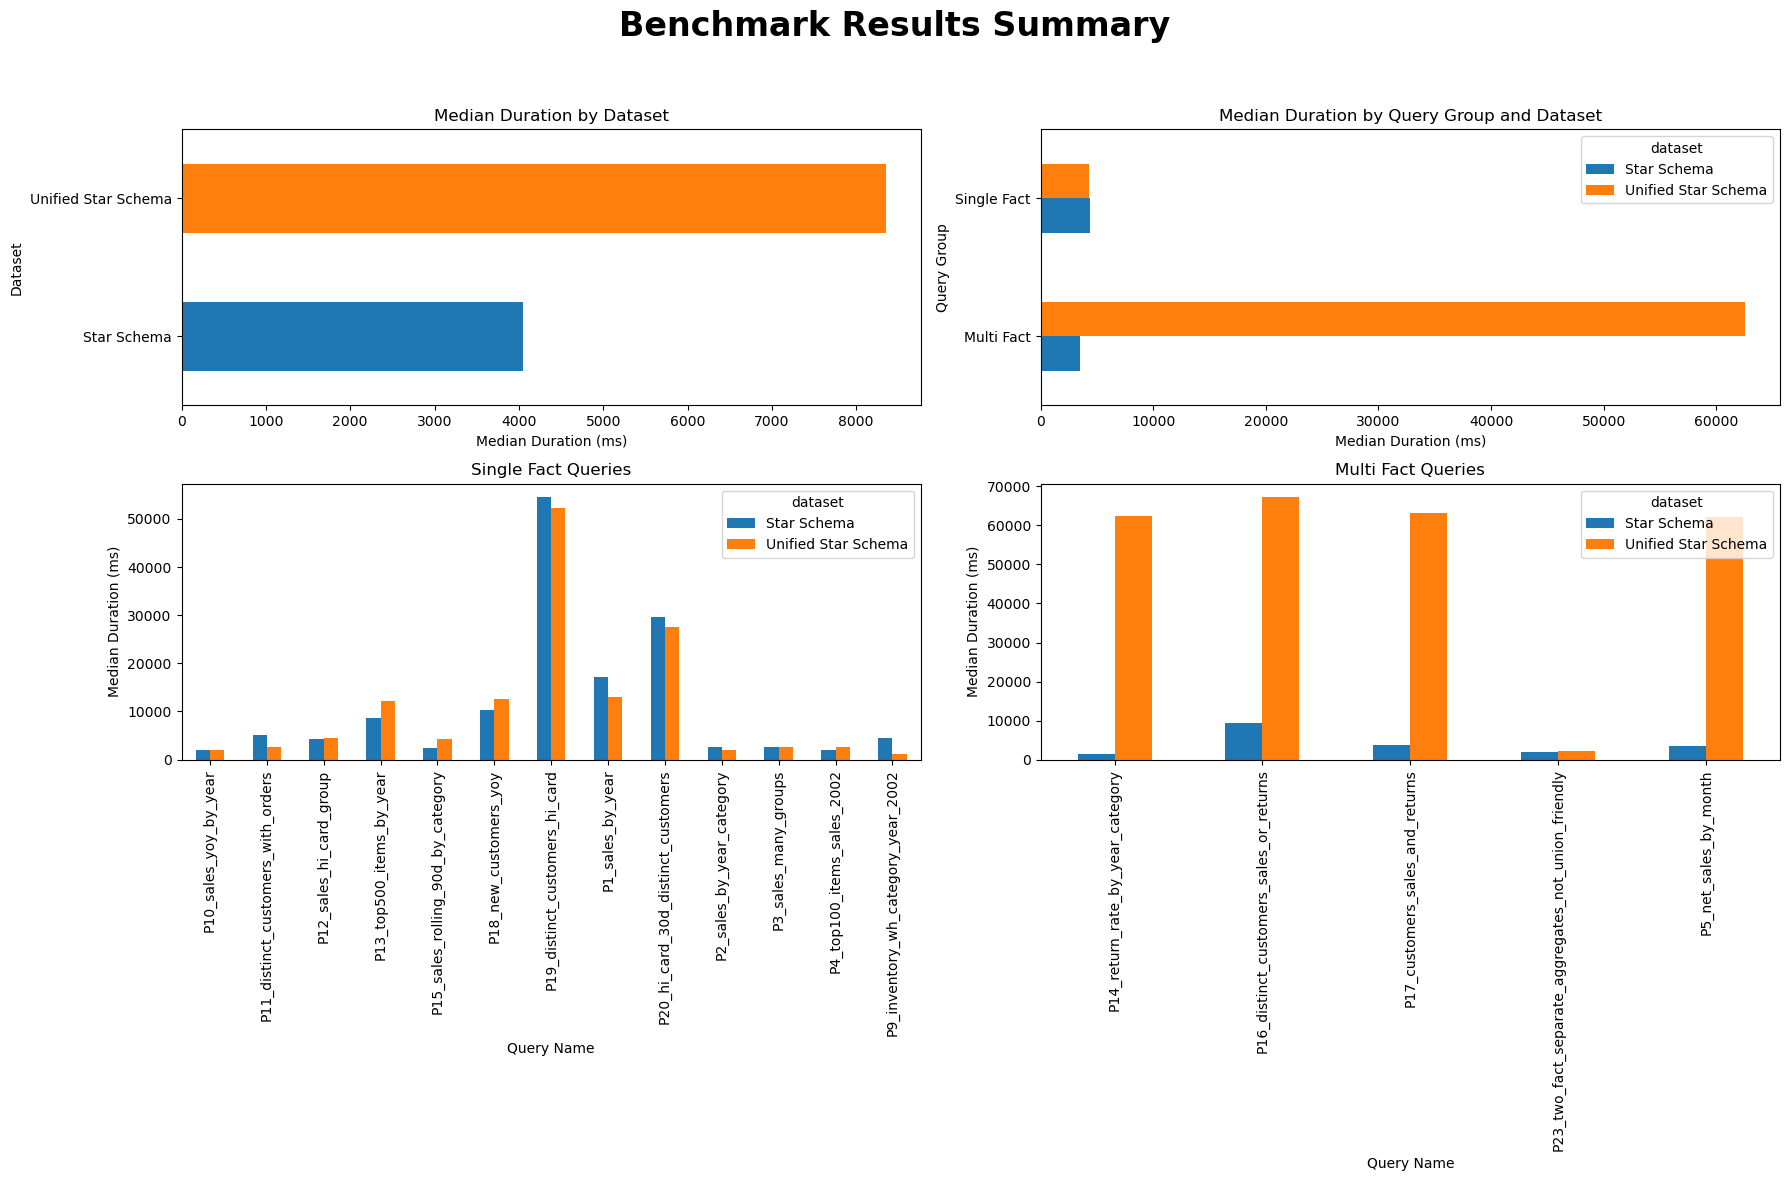

In [13]:
import matplotlib.pyplot as plt

# Prepare data
filtered_df = runs_df.query("phase == 'measured' and error.isna()")
dataset_df = filtered_df.groupby("dataset")["duration_ms"].median()
group_df = filtered_df.groupby(["query_group", "dataset"])["duration_ms"].median().unstack()

# Split detailed views by query group
single_fact_df = filtered_df.query("query_group == 'Single Fact'").groupby(["query_name", "dataset"])["duration_ms"].median().unstack()
multi_fact_df = filtered_df.query("query_group == 'Multi Fact'").groupby(["query_name", "dataset"])["duration_ms"].median().unstack()

# Create figure with 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Add Main Title
fig.suptitle("Benchmark Results Summary", fontsize=24, fontweight='bold')

# Top Left: Total by Dataset
dataset_df.plot.barh(
    ax=axes[0, 0],
    rot=0,
    color=[f"C{i}" for i in range(len(dataset_df))],
    title="Median Duration by Dataset"
)
axes[0, 0].set_xlabel("Median Duration (ms)")
axes[0, 0].set_ylabel("Dataset")

# Top Right: Total by Group
group_df.plot.barh(
    ax=axes[0, 1],
    rot=0,
    title="Median Duration by Query Group and Dataset"
)
axes[0, 1].set_xlabel("Median Duration (ms)")
axes[0, 1].set_ylabel("Query Group")

# Bottom Left: Single Fact Queries
if not single_fact_df.empty:
    single_fact_df.plot.bar(
        ax=axes[1, 0],
        rot=90,
        title="Single Fact Queries"
    )
    axes[1, 0].set_ylabel("Median Duration (ms)")
    axes[1, 0].set_xlabel("Query Name")

# Bottom Right: Multi Fact Queries
if not multi_fact_df.empty:
    multi_fact_df.plot.bar(
        ax=axes[1, 1],
        rot=90,
        title="Multi Fact Queries"
    )
    axes[1, 1].set_ylabel("Median Duration (ms)")
    axes[1, 1].set_xlabel("Query Name")

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()